Movie Review Sentiment Analysis (Kernels Only)

In [144]:
import os
from collections import Counter
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

import nltk
from sklearn.feature_extraction.text import CountVectorizer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import models, layers

In [109]:
data_dir = os.path.join('datasets', 'stack_exchange')
os.listdir(data_dir)

['sampleSubmission.csv', 'test.tsv', 'train.tsv']

In [110]:
train_path = os.path.join(data_dir, 'train.tsv')
train_df = pd.read_csv(train_path, sep='\t')

test_path = os.path.join(data_dir, 'test.tsv')
test_df = pd.read_csv(test_path, sep='\t')

train_df.head(10)

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2
5,6,1,of escapades demonstrating the adage that what...,2
6,7,1,of,2
7,8,1,escapades demonstrating the adage that what is...,2
8,9,1,escapades,2
9,10,1,demonstrating the adage that what is good for ...,2


In [111]:
train_df.isna().sum()

PhraseId      0
SentenceId    0
Phrase        0
Sentiment     0
dtype: int64

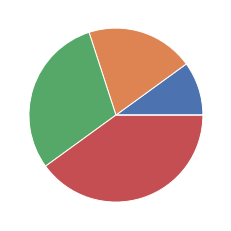

In [112]:
plt.pie(train_df['Sentiment'].unique());

In [113]:
test_df['Sentiment'] = -1
total_df = pd.concat([train_df, test_df])

### Most common words

<AxesSubplot:xlabel='freq', ylabel='words'>

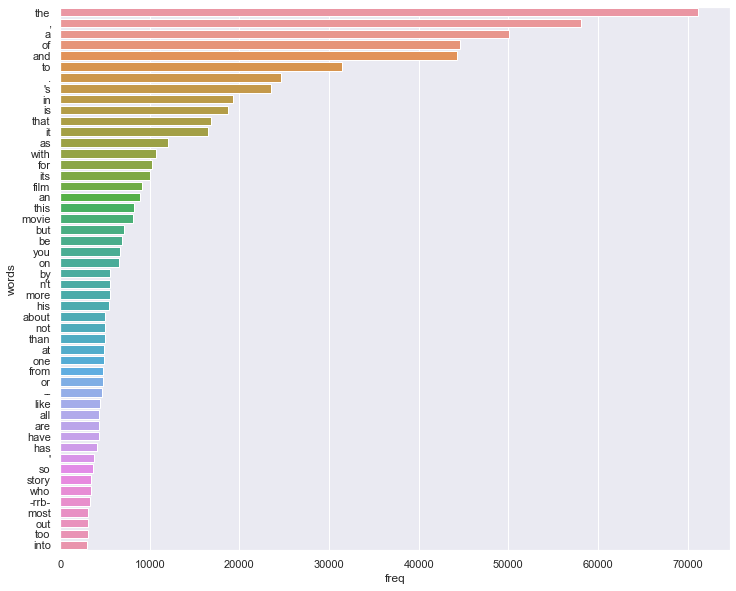

In [114]:
text = ' '.join(total_df['Phrase'].str.lower()).split()
counter = Counter(text).items()
words_df = pd.DataFrame(counter, columns=['words', 'freq'])
words_df.sort_values(by='freq', inplace=True, ascending=False)
plt.figure(figsize=(12, 10))
sns.barplot(x='freq', y='words', data=words_df.iloc[:50])

### Two grams

<AxesSubplot:xlabel='freq', ylabel='words'>

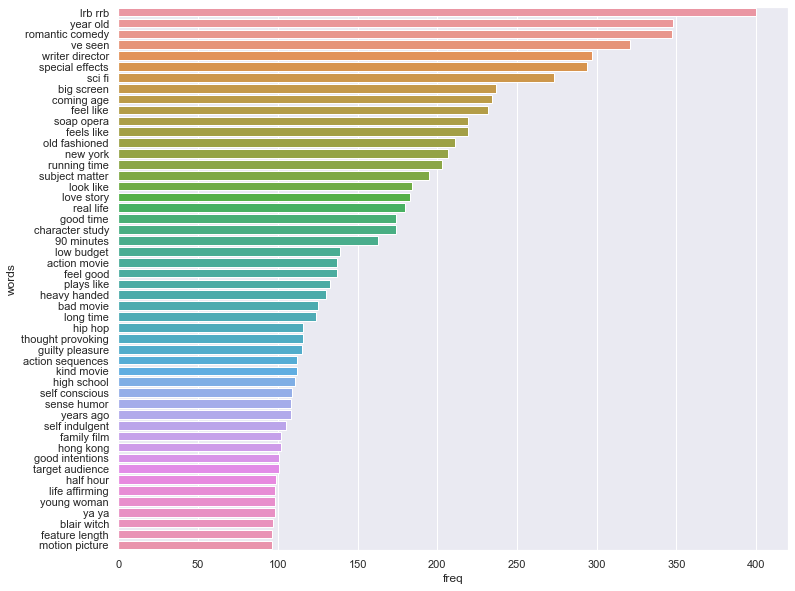

In [115]:
count_vec = CountVectorizer(ngram_range=(2, 2),
                            stop_words='english')
matrix = count_vec.fit_transform(total_df['Phrase'])
freq = matrix.sum(axis=0)
freq = np.squeeze(np.asarray(freq))
freq_data = [(word, freq[idx]) for word, idx in count_vec.vocabulary_.items()]
two_grams = pd.DataFrame(freq_data, columns=['words', 'freq'])
two_grams = two_grams.sort_values(by='freq', ascending=False)
plt.figure(figsize=(12, 10))
sns.barplot(x='freq', y='words', data=two_grams.iloc[:50])

### Tokenization

In [131]:
NUM_WORDS = 10_000

In [132]:
tokenizer = Tokenizer(NUM_WORDS, lower=True, filters='')
tokenizer.fit_on_texts(total_df['Phrase'])

In [102]:
test_mask = total_df['Sentiment'] == -1
test_df = total_df.loc[test_mask]
train_df = total_df.loc[~test_mask]

del total_df

In [142]:
X_train = tokenizer.texts_to_sequences(train_df['Phrase'])
max_len = 0
for row in X_train:
    if len(row) > max_len:
        max_len = len(row)
        
X_train = pad_sequences(X_train, maxlen = max_len, padding='post')

Y_train = train_df['Sentiment']
Y_train = to_categorical(Y_train)

### Modeling

In [152]:
model = models.Sequential()
model.add(layers.Embedding(NUM_WORDS, 100))
model.add(layers.LSTM(64, return_sequences=True))
model.add(layers.LSTM(32, recurrent_dropout=0.5))
model.add(layers.Dense(5, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', 
              metrics='accuracy')
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, None, 100)         1000000   
_________________________________________________________________
lstm_3 (LSTM)                (None, None, 64)          42240     
_________________________________________________________________
lstm_4 (LSTM)                (None, 32)                12416     
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 165       
Total params: 1,054,821
Trainable params: 1,054,821
Non-trainable params: 0
_________________________________________________________________


In [153]:
model.fit(X_train, Y_train, epochs=4, batch_size=128, validation_split=0.2)

Epoch 1/4
976/976 [==============================] - 118s 121ms/step - loss: 1.1225 - accuracy: 0.5573 - val_loss: 1.0937 - val_accuracy: 0.5705
Epoch 2/4
976/976 [==============================] - 109s 112ms/step - loss: 0.9283 - accuracy: 0.6343 - val_loss: 1.0242 - val_accuracy: 0.5944
Epoch 3/4
976/976 [==============================] - 114s 117ms/step - loss: 0.8329 - accuracy: 0.6693 - val_loss: 1.0135 - val_accuracy: 0.6043
Epoch 4/4
976/976 [==============================] - 114s 117ms/step - loss: 0.7856 - accuracy: 0.6893 - val_loss: 1.0220 - val_accuracy: 0.6021
